# Performance evaluation of the full DaniO5P model

In [1]:
import json
import os
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import scipy
import scipy.stats
import seaborn

utils_dir = '../utils'
sys.path.append(utils_dir)
import custom_plots

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [3]:
# Sublibraries
tpm_fraction_list = ['input', '80S', 'LMW', 'HMW']
pol_fraction_list = ['80S', 'LMW', 'HMW']
timepoint_list = [2, 4, 6, 10]

min_input_tpm_col = 'min_TPM_input'

tpm_cols = [f'gmean_TPM_{f}_{t}hpf' for f in tpm_fraction_list for t in timepoint_list]
input_tpm_cols = [f'gmean_TPM_input_{t}hpf' for t in timepoint_list]
input_log2_tpm_cols = [f'log2_TPM_input_{t}hpf' for t in timepoint_list]
diff_log2_tpm_input_cols = [f'diff_log2_TPM_input_{t}-2hpf' for t in timepoint_list[1:]]

mrl_cols = [f'MRL_{t}hpf' for t in timepoint_list]
log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
res_log2_mrl_cols = [f'res_log2_MRL_{t}hpf' for t in timepoint_list]

res_diff_log2_tpm_input_cols = [f'res_diff_log2_TPM_input_{t}-2hpf' for t in timepoint_list[1:]]

In [7]:
# Load measurements
measurements_df = pandas.read_csv(
    '../00_data/Zb_5UTR_MPRA_TPM_MRL.tsv.gz',
    index_col=0,
    sep='\t',
)
# Length model predictions
length_model_pred_df = pandas.read_csv(
    '../01_length_model/Zb_5UTR_MPRA_len_preds.tsv.gz',
    index_col=0,
    sep='\t',
)
# CNN model test predictions
cnn_model_pred_df = pandas.read_csv(
    '../02_cnn/Zb_5UTR_MPRA_cnn_test_predictions.tsv.gz',
    index_col=0,
    sep='\t',
)

# Concatenate data
# cnn model predictions were not made on all the data, so we need to filter
data = pandas.concat([measurements_df, length_model_pred_df, cnn_model_pred_df], axis=1)
data = data.loc[cnn_model_pred_df.index]
data

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_len_diff_log2_TPM_input_4-2hpf,pred_len_diff_log2_TPM_input_6-2hpf,pred_len_diff_log2_TPM_input_10-2hpf,pred_cnn_test_log2_MRL_2hpf,pred_cnn_test_log2_MRL_4hpf,pred_cnn_test_log2_MRL_6hpf,pred_cnn_test_log2_MRL_10hpf,pred_cnn_test_diff_log2_TPM_input_4-2hpf,pred_cnn_test_diff_log2_TPM_input_6-2hpf,pred_cnn_test_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318.0,20318,...,-0.024803,0.239230,-0.090263,-1.458773,-1.093876,-0.951682,-1.036844,-0.101084,-0.345722,-0.879938
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681.0,72681,...,0.105875,0.036108,0.057175,-0.432712,-0.186677,-0.095012,-0.102925,-0.160784,-0.123861,-0.039520
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446.0,27446,...,0.121639,-0.243822,0.069192,0.483113,0.524021,0.625693,0.616004,-0.023491,0.085291,0.157075
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092.0,113092,...,0.136392,-0.079596,0.090065,0.573451,0.308855,0.327263,0.303263,0.005142,0.124859,0.412762
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320.0,20320,...,0.137110,-0.085976,0.090756,-0.150332,0.134495,0.041598,0.153033,-0.004480,0.090186,0.256218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,chr14,-,rapgef2,478,164,0,53.048780,45.5,17462.3,17462,...,0.138223,-0.155819,0.090473,-0.229026,0.144449,0.270178,0.420581,-0.201801,-0.068943,0.175988
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,chr1,+,zic2b,281,145,1,40.689655,16.4,19629.1,19629,...,0.128484,-0.034795,0.081877,0.486780,0.350007,0.346714,0.241248,0.018923,0.159062,0.308922
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,chr1,+,zic2b,281,146,1,39.726027,19.3,19629.2,19629,...,0.129923,-0.041210,0.083405,0.369464,0.087115,0.103181,-0.209837,0.116786,0.044556,0.175206
ENSDARG00000101903_ENSDART00000168627_8580_zfyve9a_20081.1,chr2,-,zfyve9a,304,156,3,41.666667,22.9,20081.1,20081,...,0.138648,-0.105085,0.092114,0.260718,0.103335,0.274023,0.036972,0.114199,0.056542,0.037466


In [8]:
max_seq_len = data['insert_length'].max()

In [10]:
# Load chromosomal splits
with open('../02_cnn/chr_splits.json', 'r') as f:
    chr_splits_info = json.load(f)
# chr_splits_info

In [11]:
# Add full model predictions
for output_idx, output_name in enumerate(log2_mrl_cols + diff_log2_tpm_input_cols):
    data['pred_test_' + output_name] = data['pred_len_' + output_name] + data['pred_cnn_test_' + output_name]

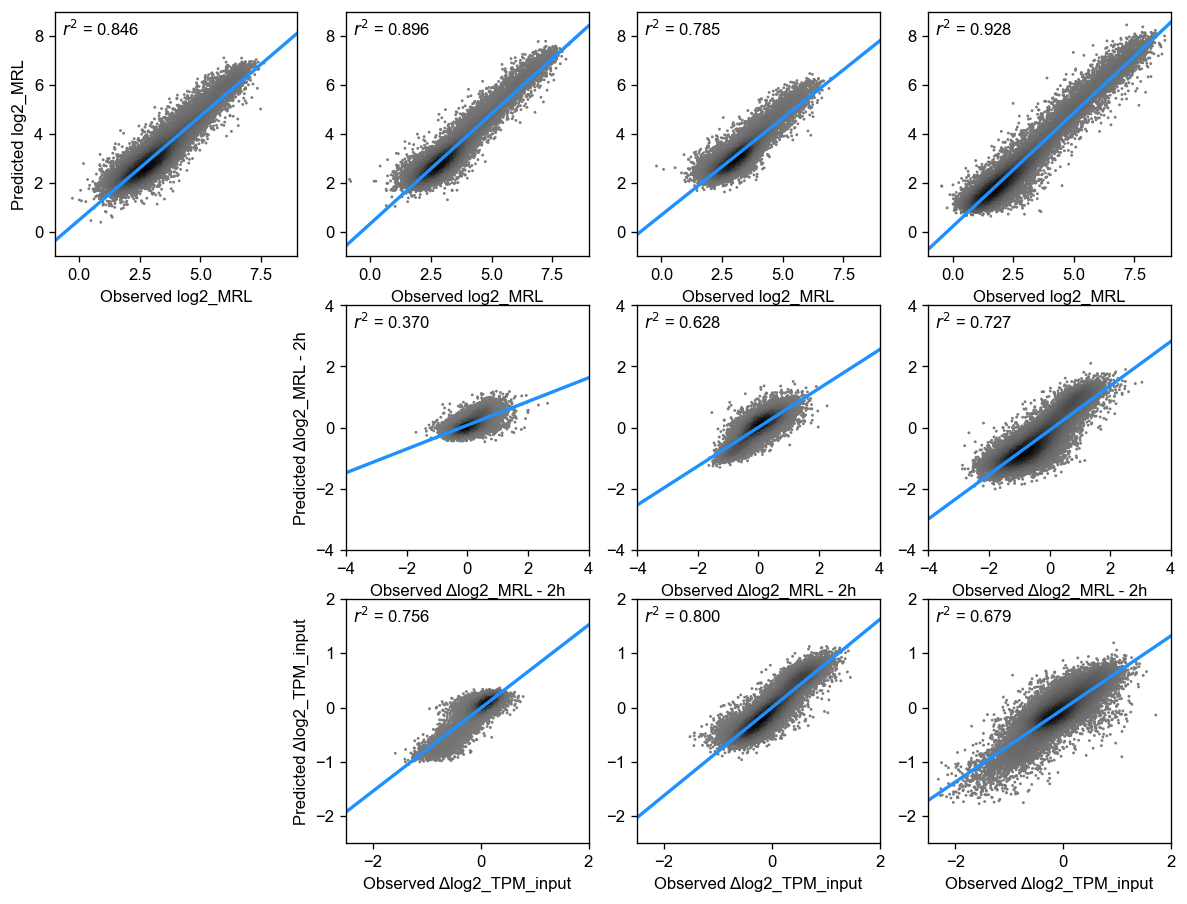

In [13]:
# Plot full model performance
fig, axes = pyplot.subplots(
    3,
    len(timepoint_list),
    figsize=(3*len(timepoint_list), 3*3),
)

for y_idx, ycol in enumerate(log2_mrl_cols):
    ax = axes[0, y_idx]

    lrres = custom_plots.plot_scatter_shaded(
        data[ycol],
        data['pred_test_' + ycol],
        ax,
        xlim=(-1, 9),
        ylim=(-1, 9),
        linreg=True,
    )

    ax.set_xlabel('Observed log2_MRL')
    if y_idx==0:
        ax.set_ylabel('Predicted log2_MRL')

axes[1, 0].set_visible(False)
for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
    ax = axes[1, y_idx+1]

    lrres = custom_plots.plot_scatter_shaded(
        data[ycol] - data[log2_mrl_cols[0]],
        data['pred_test_' + ycol] - data['pred_test_' + log2_mrl_cols[0]],
        ax,
        xlim=(-4, 4),
        ylim=(-4, 4),
        linreg=True,
    )

    ax.set_xlabel('Observed Δlog2_MRL - 2h')
    if y_idx==0:
        ax.set_ylabel('Predicted Δlog2_MRL - 2h')

axes[2, 0].set_visible(False)
for y_idx, ycol in enumerate(diff_log2_tpm_input_cols):
    ax = axes[2, y_idx+1]

    lrres = custom_plots.plot_scatter_shaded(
        data[ycol],
        data['pred_test_' + ycol],
        ax,
        xlim=(-2.5, 2),
        ylim=(-2.5, 2),
        linreg=True,
    )

    ax.set_xlabel('Observed Δlog2_TPM_input')
    if y_idx==0:
        ax.set_ylabel('Predicted Δlog2_TPM_input')

fig.savefig('full_model_prediction.svg', dpi=200, bbox_inches='tight')
# fig.savefig('full_model_prediction.png', dpi=200, bbox_inches='tight')

In [14]:
# Calculate r^2 of length model for performance bar plots
r2_len_dict = {}
for y_idx, ycol in enumerate(log2_mrl_cols):
    lrres = scipy.stats.linregress(
        data[ycol],
        data['pred_len_' + ycol],
    )
    r2_len_dict[ycol] = lrres.rvalue**2

for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
    lrres = scipy.stats.linregress(
        data[ycol] - data[log2_mrl_cols[0]],
        data['pred_len_' + ycol] - data['pred_len_' + log2_mrl_cols[0]],
    )
    r2_len_dict['diff_' + ycol[:-3] + '-2hpf'] = lrres.rvalue**2

for y_idx, ycol in enumerate(diff_log2_tpm_input_cols):
    lrres = scipy.stats.linregress(
        data[ycol],
        data['pred_len_' + ycol],
    )
    r2_len_dict[ycol] = lrres.rvalue**2

r2_len_df = pandas.DataFrame({k: [v] for k, v in r2_len_dict.items()})
r2_len_df

,log2_MRL_2hpf,log2_MRL_4hpf,log2_MRL_6hpf,log2_MRL_10hpf,diff_log2_MRL_4-2hpf,diff_log2_MRL_6-2hpf,diff_log2_MRL_10-2hpf,diff_log2_TPM_input_4-2hpf,diff_log2_TPM_input_6-2hpf,diff_log2_TPM_input_10-2hpf
0,0.700423,0.824522,0.638613,0.850572,0.16249,0.401012,0.512842,0.674811,0.669318,0.304


In [15]:
# Calculate r^2 of full model for performance bar plots
r2_list = []
for split_idx, chr_split_info in enumerate(chr_splits_info):

    # Select data from test chromosomes
    test_chrs = chr_split_info['test']
    data_test = data[data['chr'].isin(test_chrs)]

    r2_test_dict = {}
    for y_idx, ycol in enumerate(log2_mrl_cols):
        lrres = scipy.stats.linregress(
            data_test[ycol],
            data_test['pred_test_' + ycol],
        )
        r2_test_dict[ycol] = lrres.rvalue**2

    for y_idx, ycol in enumerate(log2_mrl_cols[1:]):
        lrres = scipy.stats.linregress(
            data_test[ycol] - data_test[log2_mrl_cols[0]],
            data_test['pred_test_' + ycol] - data_test['pred_test_' + log2_mrl_cols[0]],
        )
        r2_test_dict['diff_' + ycol[:-3] + '-2hpf'] = lrres.rvalue**2

    for y_idx, ycol in enumerate(diff_log2_tpm_input_cols):
        lrres = scipy.stats.linregress(
            data_test[ycol],
            data_test['pred_test_' + ycol],
        )
        r2_test_dict[ycol] = lrres.rvalue**2

    r2_list.append(r2_test_dict)

r2_full_df = pandas.DataFrame(r2_list)
r2_full_df

,log2_MRL_2hpf,log2_MRL_4hpf,log2_MRL_6hpf,log2_MRL_10hpf,diff_log2_MRL_4-2hpf,diff_log2_MRL_6-2hpf,diff_log2_MRL_10-2hpf,diff_log2_TPM_input_4-2hpf,diff_log2_TPM_input_6-2hpf,diff_log2_TPM_input_10-2hpf
0,0.876792,0.918069,0.823222,0.942045,0.386997,0.680341,0.756211,0.787015,0.814293,0.686743
1,0.849502,0.898508,0.797307,0.927554,0.397203,0.627877,0.739316,0.764274,0.805073,0.699908
2,0.860152,0.909100,0.811369,0.936310,0.358712,0.629628,0.731917,0.771623,0.803547,0.675028
3,0.831387,0.892902,0.778111,0.929751,0.362377,0.600025,0.718935,0.753271,0.809836,0.696050
4,0.842440,0.890830,0.773560,0.922780,0.373911,0.648540,0.722798,0.726021,0.795524,0.688205
5,0.845983,0.891925,0.783087,0.929126,0.382263,0.632406,0.750917,0.769799,0.801445,0.684584
6,0.842782,0.897274,0.785018,0.921838,0.397995,0.639971,0.729629,0.768546,0.799903,0.688661
7,0.836300,0.887763,0.771565,0.924997,0.371652,0.628055,0.724321,0.755008,0.807611,0.696931
8,0.843917,0.888417,0.772908,0.920048,0.384589,0.644567,0.721760,0.758964,0.796513,0.650315
9,0.842005,0.887494,0.769373,0.924647,0.346923,0.602863,0.713487,0.724945,0.795278,0.666938


In [16]:
r2_full_df.mean(axis=0)

log2_MRL_2hpf                  0.847126
log2_MRL_4hpf                  0.896228
log2_MRL_6hpf                  0.786552
log2_MRL_10hpf                 0.927910
diff_log2_MRL_4-2hpf           0.376262
diff_log2_MRL_6-2hpf           0.633427
diff_log2_MRL_10-2hpf          0.730929
diff_log2_TPM_input_4-2hpf     0.757947
diff_log2_TPM_input_6-2hpf     0.802902
diff_log2_TPM_input_10-2hpf    0.683337
dtype: float64

C:\Users\casti\AppData\Local\Temp\ipykernel_37352\1737335765.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([s.replace('diff_', 'Δ') for s in cols_to_plot], rotation=90)


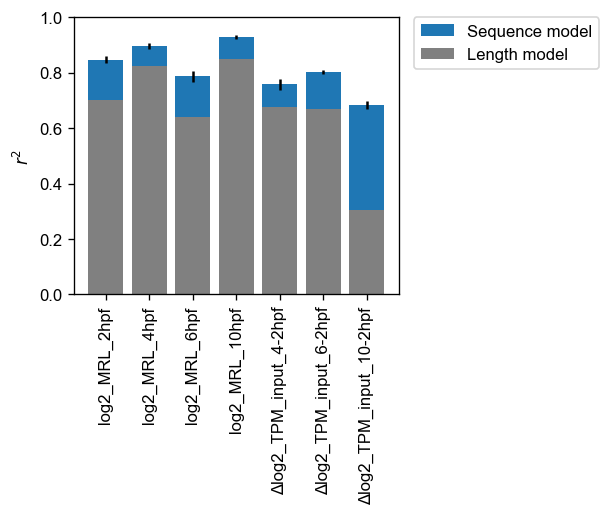

In [17]:
# Plot r^2 summary
# cols_to_plot = r2_full_df.columns.to_list()
cols_to_plot = log2_mrl_cols + diff_log2_tpm_input_cols

fig, ax = pyplot.subplots(figsize=(0.5*len(cols_to_plot), 3))
ax.bar(cols_to_plot, r2_full_df[cols_to_plot].mean(axis=0), yerr=r2_full_df[cols_to_plot].std(axis=0), label='Sequence model')
ax.bar(cols_to_plot, [r2_len_dict[k] for k in cols_to_plot], color='grey', label='Length model')
ax.set_xticklabels([s.replace('diff_', 'Δ') for s in cols_to_plot], rotation=90)
ax.set_ylabel('$r^2$')
ax.set_ylim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.03))
fig.savefig('len_vs_seq_model.svg', dpi=200, bbox_inches='tight')

C:\Users\casti\AppData\Local\Temp\ipykernel_37352\117837668.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([s.replace('diff_', 'Δ') for s in cols_to_plot], rotation=90)


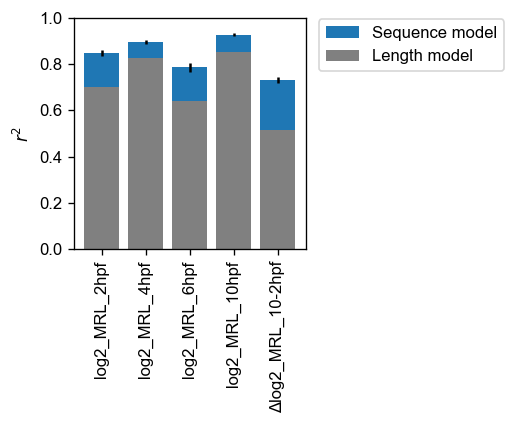

In [18]:
# Plot r^2 summary
# cols_to_plot = r2_full_df.columns.to_list()
cols_to_plot = log2_mrl_cols + ['diff_log2_MRL_10-2hpf']

fig, ax = pyplot.subplots(figsize=(0.5*len(cols_to_plot), 2.5))
ax.bar(cols_to_plot, r2_full_df[cols_to_plot].mean(axis=0), yerr=r2_full_df[cols_to_plot].std(axis=0), label='Sequence model')
ax.bar(cols_to_plot, [r2_len_dict[k] for k in cols_to_plot], color='grey', label='Length model')
ax.set_xticklabels([s.replace('diff_', 'Δ') for s in cols_to_plot], rotation=90)
ax.set_ylabel('$r^2$')
ax.set_ylim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.03))
fig.savefig('len_vs_seq_model_mrl_only.svg', dpi=200, bbox_inches='tight')